# Method 1 - Least Squares Regression

Statistical evaluation of failure stresses. 

The process is as follows:
- Calculate the stress at failure for each specimen and sort them in increasing order of magnitude: $ \sigma_i $, where $ i $ is the rank number.
- Calculate the probability of failure $ P_{f,i} $ for each measured value. Use the following estimator:
$
  P_{f,i} = \frac{i}{n+1}
$
  where $ n $ is the number of tested samples.
- Put the Weibull distribution into linearized form. Enter the measured data into the Weibull mesh.
- Fit the data by linear regression. Find the slope, the intercept, and the coefficient of determination $ R^2 $.
- Determine the Weibull parameters $ \lambda $ (shape parameter) and $ \beta $ (scale parameter).
- Calculate the confidence interval $ C $ and plot it on the Weibull mesh.
- Determine the 5% fractile value of the bending tensile strength $ f_y $ using the regression line and using the confidence interval. In the case of the confidence interval, use the target goal seek.
- Plot the cumulative distribution function $ F(x) $ and the density function $ f(x) $.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress, t
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

### Input the failure stress rates from experimental data.
1. Select the desired stress fractile and confidence interval.

In [2]:
stress_rates = {
    "dataset-1": np.array([57.0571, 53.1429, 57.2857, 58.3429, 58.6286, 62.8000, 67.7143, 68.8857, 76.3429, 76.4571, 77.4571, 79.0000, 82.1714, 87.5429]),
    "dataset-2": np.array([41.26, 42.54, 44.31,44.43,44.67,45.02, 45.37,46.08, 46.08, 46.55,47.86,48.21,48.21,48.31, 49.63,50.34, 50.43, 50.69,50.78, 51.05, 51.05,51.05,51.76, 53.17]),
    "dataset-3": np.array([84.1,95.4,112.4,101.4,112.4,118.3,126.3,128.3,129.3,147,160.8,167.1,171,175,176,183,188.9,190.9,192.9,193.9,194.9,195.9,196.9,198.9,198.9,203.9,205.9,208,208.8,210.8,224.7,253.6]),
}

target_P_f = 0.05   # Target stress fractile
target_alpha = 0.10 # Target confidence interval for the t-values ​​of the Student's t-distribution

### Start of Statistical evaluation

In [3]:
def steyx(x, y):
    n = len(x)
    if len(y) != n:
        raise ValueError("x and y must have the same length")
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the slope and intercept
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    intercept = y_mean - slope * x_mean

    # Calculate predicted y-values
    y_pred = slope * x + intercept

    # Calculate standard error
    se = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    return se

# Define confidence function
def CI(x):
    return t_value * se * np.sqrt(1/n + (x - mean_ln_stress)**2 / np.sum((ln_stress - mean_ln_stress)**2))

# Define the function of the upper confidence interval
def f_upper(x):
    return slope*x + intercept - CI(x) 

# Define the function of the lower confidence interval
def f_lower(x):
    return slope*x + intercept + CI(x) 

# Define a function that subtracts the target value
def goal_seek_function_CI_upper(x):
    return f_upper(x) - target_value

# Define a function that subtracts the target value
def goal_seek_function_CI_lower(x):
    return f_lower(x) - target_value

# Weibull PDF
def weibull_pdf(x, beta, lambda_):
    return (lambda_ / beta) * (x / beta)**(lambda_ - 1) * np.exp(-(x / beta)**lambda_)

# Weibull CDF
def weibull_cdf(x, beta, lambda_):
    return 1 - np.exp(-(x / beta)**lambda_)

x_5 is 3.8233143386823807
The value of x that makes P_f(x) = -2.9701952490421655 is: 3.8798551676529685
The value of x that makes P_f(x) = -2.9701952490421655 is: 3.7481658869112016
95% Confidence Interval of 5.0%  Fractile: (42.44, 48.42) MPa
5.0% Fractile Stress: 45.76 MPa
x_5 is 3.7150709216668787
The value of x that makes P_f(x) = -2.9701952490421655 is: 3.724968045329244
The value of x that makes P_f(x) = -2.9701952490421655 is: 3.7039532854671733
95% Confidence Interval of 5.0%  Fractile: (40.61, 41.47) MPa
5.0% Fractile Stress: 41.06 MPa
x_5 is 4.4931504392415516
The value of x that makes P_f(x) = -2.9701952490421655 is: 4.535209021715688
The value of x that makes P_f(x) = -2.9701952490421655 is: 4.445650836020888
95% Confidence Interval of 5.0%  Fractile: (85.26, 93.24) MPa
5.0% Fractile Stress: 89.40 MPa


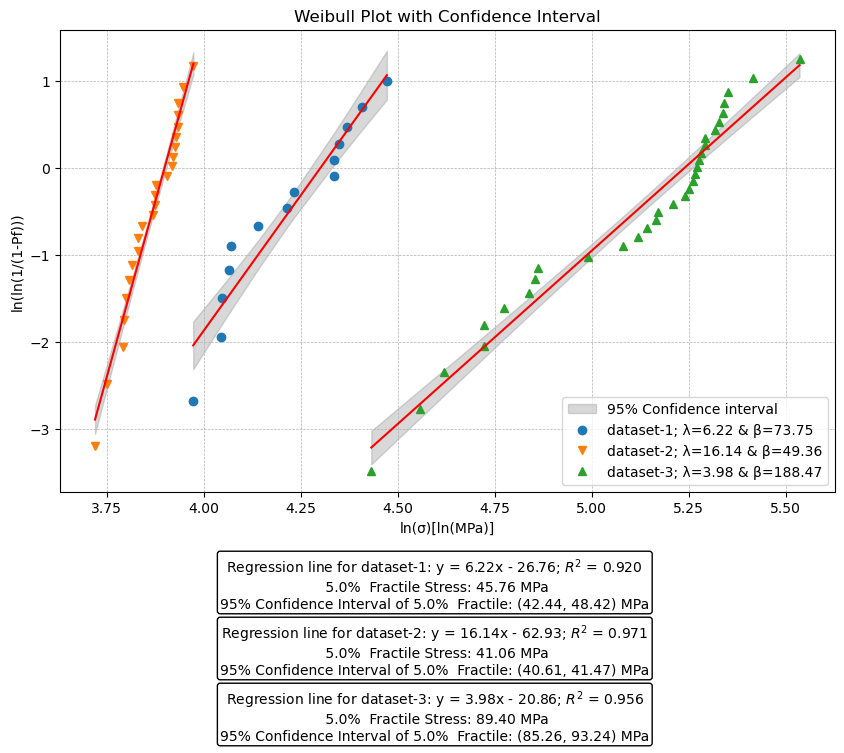

In [4]:
plt.figure(figsize=(10, 6))
i = 0; 


# Initialize an empty dictionary to store the scale & shape value of a Weibull distribution corresponding to each dataset.
Weibull_distribution_parameters = {}
for dataset, stress_rate in stress_rates.items():
    
    # Sort the stress in increasing order
    sorted_stress = np.sort(stress_rate)

    # Calculate probability of failure (P_f,i)
    n = len(sorted_stress)

    P_f = np.array([(i + 1) / (n + 1) for i in range(n)])

    # Linearize the Weibull distribution
    ln_stress = np.log(sorted_stress)

    ln_ln_Pf = np.log(np.log(1 / (1 - P_f)))

    # Perform linear regression
    slope, intercept, r_value, p_value, std_error = linregress(ln_stress, ln_ln_Pf)

    std_err = steyx(ln_stress, ln_ln_Pf)

    # Calculate the standard error
    se = std_err

    # Calculate the t-value for 95% confidence
    alpha = target_alpha
    t_value = t.ppf(1 - alpha/2, df=n-2)

    # Calculate the confidence interval
    mean_ln_stress = np.mean(ln_stress)

    C = t_value * se * np.sqrt(1/n + (ln_stress - mean_ln_stress)**2 / np.sum((ln_stress - mean_ln_stress)**2))

    # Determine the x% fractile
    Pf_x = target_P_f
    ln_ln_Pf_5 = np.log(np.log(1 / (1 - Pf_x)))
    x_5 = (ln_ln_Pf_5 - intercept) / slope  
    print(f"x_5 is {x_5}")
    stress_x_percentile = np.exp(x_5)

    # Set the target value
    # Determine the 5% fractile
    target_value = np.log(np.log(1 / (1 - Pf_x)))

    # Initial guess
    initial_guess = 3.0

    # Use fsolve to perform the goal seek for the upper value of the confidence interval
    solution_CI_upper = fsolve(goal_seek_function_CI_upper, initial_guess)
    # Use fsolve to perform the goal seek for the lower value of the confidence interval
    solution_CI_lower = fsolve(goal_seek_function_CI_lower, initial_guess)

    # Weibull Parameters estimation
    shape = slope
    scale = np.exp(-intercept/slope)
    Weibull_distribution_parameters[dataset] = (scale,shape)

    # Output the solution
    print(f"The value of x that makes P_f(x) = {target_value} is: {solution_CI_upper[0]}")
    print(f"The value of x that makes P_f(x) = {target_value} is: {solution_CI_lower[0]}")
    stress_x_percentile_CI_upper = np.exp(solution_CI_upper[0])
    stress_x_percentile_CI_lower = np.exp(solution_CI_lower[0])

    print(f"{int((1-target_alpha/2)*100)}% Confidence Interval of {target_P_f*100}%  Fractile: ({stress_x_percentile_CI_lower:.2f}, {stress_x_percentile_CI_upper:.2f}) MPa")
    print(f"{target_P_f*100}% Fractile Stress: {stress_x_percentile:.2f} MPa")

    # Plot with confidence interval
    # List of marker symbols to cycle through
    # Uncomment more symbols for larger number of datasets
    markers = [
        #'.',  # Point
        #',',  # Pixel
        'o',  # Circle
        'v',  # Triangle down
        '^',  # Triangle up
        #'<',  # Triangle left
        #'>',  # Triangle right
        #'1',  # Tri-down
        #'2',  # Tri-up
        #'3',  # Tri-left
        #'4',  # Tri-right
        's',  # Square
        #'p',  # Pentagon
        #'*',  # Star
        #'h',  # Hexagon 1
        #'H',  # Hexagon 2
        #'+',  # Plus
        #'x',  # X
        'D',  # Diamond
        #'d',  # Thin diamond
        #'|',  # Vertical line
        #'_',  # Horizontal line
    ]

    # Select marker symbol from the list
    marker = markers[i % len(markers)]

    #plt.plot(ln_stress, ln_ln_Pf, marker, label=f'{dataset}; \u03BB={shape:.2f} & \u03B2={scale:.2f}')
    plt.fill_between(ln_stress, slope * ln_stress + intercept - C, slope * ln_stress + intercept + C, color='grey', alpha=0.3, label=f'{int((1-target_alpha/2)*100)}% Confidence interval')
    plt.plot(ln_stress, ln_ln_Pf, marker, label=f'{dataset}; \u03BB={shape:.2f} & \u03B2={scale:.2f}')
    plt.plot(ln_stress, slope * ln_stress + intercept, 'r')
    #plt.fill_between(ln_stress, slope * ln_stress + intercept - C, slope * ln_stress + intercept + C, color='grey', alpha=0.3, label='Confidence interval')

    # Add regression equation and R-squared below the figure
    regression_text = f"y = {slope:.2f}x {'+' if intercept > 0 else '-'} {abs(intercept):.2f}; $R^2$ = {r_value**2:.3f}"
    stress_text = f"{target_P_f*100}%  Fractile Stress: {stress_x_percentile:.2f} MPa\n" \
                  f"{int((1-target_alpha/2)*100)}% Confidence Interval of {target_P_f*100}%  Fractile: ({stress_x_percentile_CI_lower:.2f}, {stress_x_percentile_CI_upper:.2f}) MPa"
    plt.figtext(0.5, -0.08 - i * 0.11,
        f"Regression line for {dataset}: {regression_text}\n {stress_text}",
        wrap=True, horizontalalignment='center', fontsize=10,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    i += 1

    
plt.xlabel(f'ln(\u03C3)[ln(MPa)]')
plt.ylabel('ln(ln(1/(1-Pf)))')


plt.title('Weibull Plot with Confidence Interval')

# Get handles and labels, then filter to make them unique
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels_set = set()
unique_handles_labels = []

for handle, label in zip(handles, labels):
    if label not in unique_labels_set:
        unique_handles_labels.append((handle, label))
        unique_labels_set.add(label)

# Construct separate lists for handles and labels, and position the legend
if unique_handles_labels:
    unique_handles, unique_labels = zip(*unique_handles_labels)
    plt.legend(unique_handles, unique_labels, loc='lower right')
#plt.grid(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


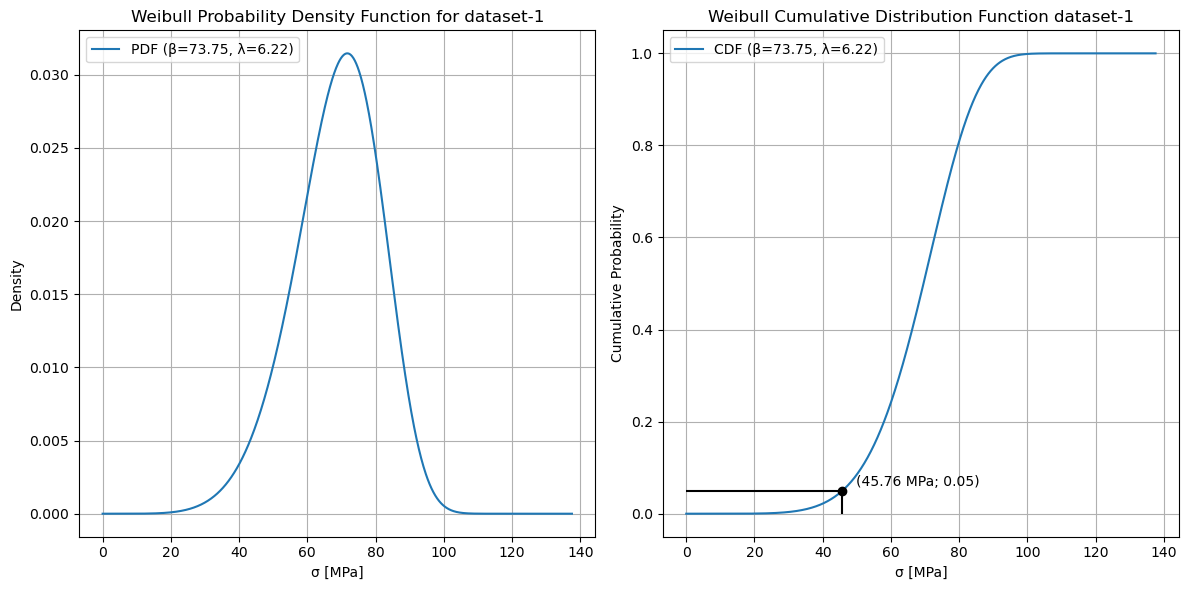

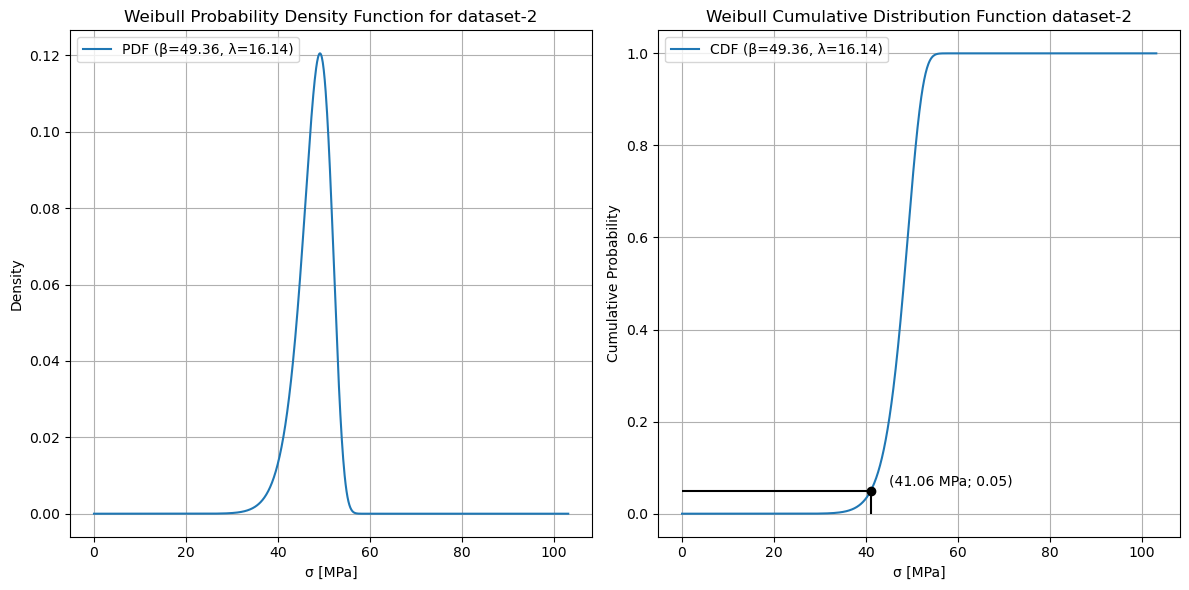

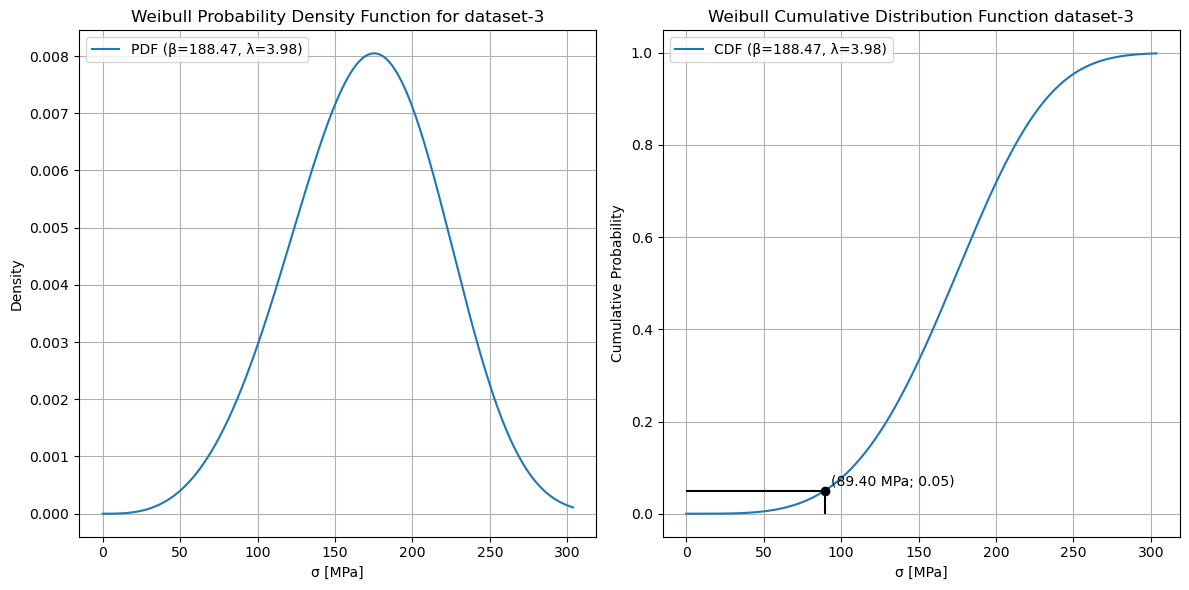

In [5]:

for dataset, stress_rate in stress_rates.items():
    # Creating a range of x values
    x = np.linspace(0,max(stress_rate)+50,1000)
    # Calculate PDF and CDF
    pdf_values = weibull_pdf(x, Weibull_distribution_parameters[dataset][0], Weibull_distribution_parameters[dataset][1])
    cdf_values = weibull_cdf(x, Weibull_distribution_parameters[dataset][0], Weibull_distribution_parameters[dataset][1])
    # Calculate the x% fractile
    target_percentile = 1 - target_P_f
    x_percentile = Weibull_distribution_parameters[dataset][0] * (-np.log(target_percentile))**(1/Weibull_distribution_parameters[dataset][1])
    # Plotting
    plt.figure(figsize=(12, 6))
    # Plot PDF
    plt.subplot(1, 2, 1)
    plt.plot(x, pdf_values, label=f"PDF (\u03B2={Weibull_distribution_parameters[dataset][0]:.2f}, \u03BB={Weibull_distribution_parameters[dataset][1]:.2f})")
    plt.title(f'Weibull Probability Density Function for {dataset}')
    plt.xlabel('\u03C3 [MPa]')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend(loc='upper left')
    # Plot CDF
    plt.subplot(1, 2, 2)
    plt.plot(x, cdf_values, label=f"CDF (\u03B2={Weibull_distribution_parameters[dataset][0]:.2f}, \u03BB={Weibull_distribution_parameters[dataset][1]:.2f})")
    plt.hlines(target_P_f, 0, x_percentile, color='black', linestyle='-')
    plt.vlines(x_percentile, 0, target_P_f, color='black', linestyle='-')
    # Add a circular marker at the 5% fractile
    plt.scatter([x_percentile], [target_P_f], color='black', zorder=5)
    # Annotate the 5% fractile
    plt.text(x_percentile + 4, target_P_f + 0.01, f'({x_percentile:.2f} MPa; 0.05)', fontsize=10)
    plt.title(f'Weibull Cumulative Distribution Function {dataset}')
    plt.xlabel('\u03C3 [MPa]')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
